In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

In [ ]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        return sequence

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        # print("encoder x shape: ", x.shape)
        # x = x.unsqueeze(dim=0)
        # x = x.permute(1, 2, 0)
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        
        # hidden = hidden.permute(1, 2, 0)
        # cell = cell.permute(1, 2, 0)
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        # hidden = self.fc(hidden.to(device))
        # cell = self.fc(cell.to(device))
        
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        # print("decoder x shaep: ", x.shape)
        # x = x.reshape(512, 1, 64)
        # hidden = (hidden[0].unsqueeze(dim=0), hidden[1].unsqueeze(dim=0))
        hidden = (hidden[0], hidden[1])
        # print("x shape: ", x.shape)
        # print("hidden shaep: ", hidden[0].shape)
        # print("hidden shaep: ", hidden[1].shape)

        output, (hidden, cell) = self.lstm(x, hidden)

        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, seq_len, num_layers, device
    ):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )


        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        # x = x.squeeze()
        # print("x shape: ", x.shape)
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        # print("enc h deivce:", enc_hidden.shape)
        # enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        # print("z shape: ", z.shape)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        # print("x hat : ", x_hat.shape)
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        # print("reconds shape: ", recons.shape)
        # print("input shape: ", input.shape)
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

0        -9.8184
1        -9.8489
2        -9.6602
3        -9.6507
4        -9.7030
           ...  
161275   -9.4032
161276   -9.5201
161277   -9.3682
161278   -8.6702
161279   -8.7211
Name: chest acceleration X-axis, Length: 161280, dtype: float64

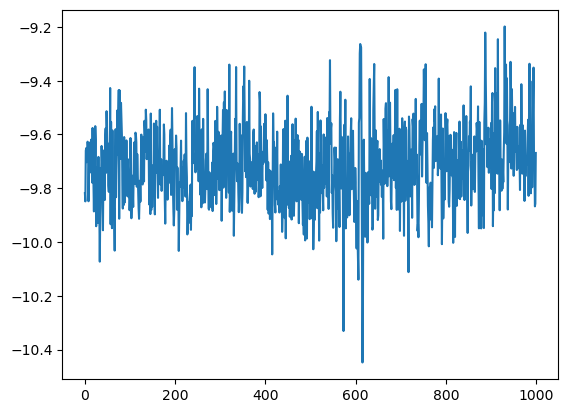

In [ ]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info
plt.plot(dataset[:1000])

dataset

In [ ]:
LOAD_MODEL = True
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

batch_size = 128
input_size = 1
hidden_size = 256
latent_size = 128
sequence_len = 128
num_layers = 2

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\128_latent_state_dict'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)

model.to(device)
print("training on: ", device)
print(model)

decoder layers:  2
training on:  cuda
LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    print("datas shape: ", datas.shape)
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x00000214C6620DD0>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_2108\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [ ]:
train_loss = []
test_loss = []

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )

        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            train_loss.append(float(mloss.mean()))


        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})
                test_loss.append(float(mloss.mean()))

        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [ ]:
iterations = 20000
train(iterations, model, train_loader, train_loader)

  0%|          | 0/19 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_2108\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
training: 1008it [01:00, 16.59it/s, train_loss=23.5]
  5%|▌         | 1/19 [01:25<25:30, 85.02s/it]

Evaluation Score : [11.805569791264595]


training: 1008it [01:00, 16.69it/s, train_loss=25]
 11%|█         | 2/19 [02:49<24:01, 84.80s/it]

Evaluation Score : [12.030986490711156]


training: 1008it [01:00, 16.61it/s, train_loss=22.9]
 16%|█▌        | 3/19 [04:14<22:40, 85.03s/it]

Evaluation Score : [11.832884547640644]


training: 1008it [01:01, 16.49it/s, train_loss=23.2]
 21%|██        | 4/19 [05:40<21:19, 85.32s/it]

Evaluation Score : [11.191683042439676]


training: 1008it [01:01, 16.50it/s, train_loss=22.4]
 26%|██▋       | 5/19 [07:06<19:55, 85.43s/it]

Evaluation Score : [11.348908592488558]


training: 1008it [01:01, 16.49it/s, train_loss=23.5]
 32%|███▏      | 6/19 [08:32<18:31, 85.53s/it]

Evaluation Score : [11.633185314066294]


training: 1008it [01:01, 16.50it/s, train_loss=15.3]
 37%|███▋      | 7/19 [09:57<17:06, 85.57s/it]

Evaluation Score : [11.326845236529138]


training: 1008it [01:00, 16.53it/s, train_loss=19.1]
 42%|████▏     | 8/19 [11:23<15:40, 85.52s/it]

Evaluation Score : [11.577020348685364]


training: 1008it [01:01, 16.52it/s, train_loss=16.9]
 47%|████▋     | 9/19 [12:48<14:15, 85.50s/it]

Evaluation Score : [11.325740113588315]


training: 1008it [01:00, 16.53it/s, train_loss=30.2]
 53%|█████▎    | 10/19 [14:13<12:49, 85.45s/it]

Evaluation Score : [14.083736643269066]


training: 1008it [01:01, 16.43it/s, train_loss=28.5]
 58%|█████▊    | 11/19 [15:39<11:24, 85.58s/it]

Evaluation Score : [14.328688682256532]


training: 1008it [01:01, 16.48it/s, train_loss=40.3]
 58%|█████▊    | 11/19 [16:52<12:16, 92.04s/it]


RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(model.state_dict(), 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\128_latent_state_dict')

In [ ]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:
            # print(batch.shape)
            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary
            # print("x shape: ", x.shape)
            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )
            # print('x shape: ', x.shape)
            mloss, recon_x, info = model(x)
            
            # print("recon x shape: ", recon_x.shape)
            recon_x = recon_x[:, 0]
            # print("recon x shape: ", recon_x.shape)
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [ ]:
reconstruction = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2108\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


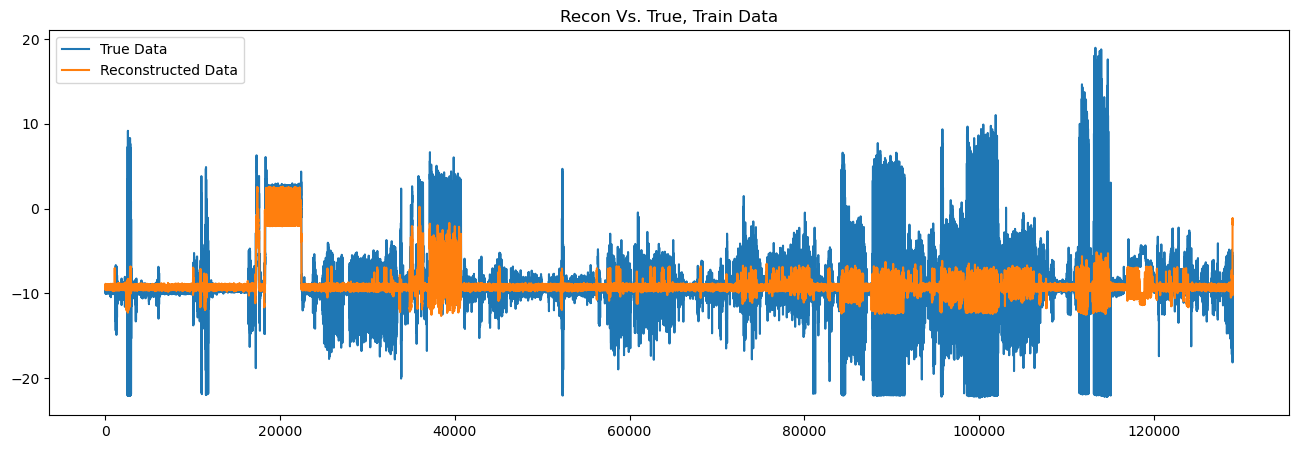

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

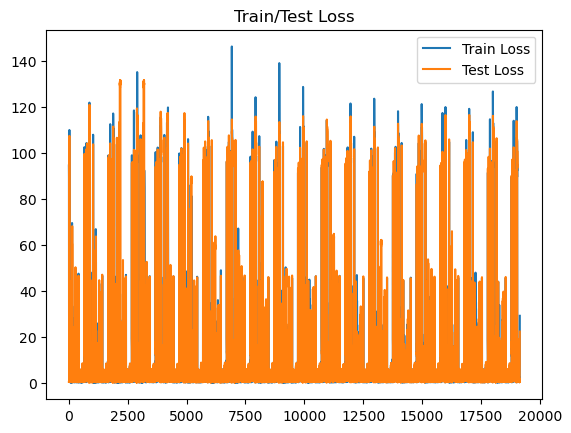

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title("Train/Test Loss")
plt.legend()

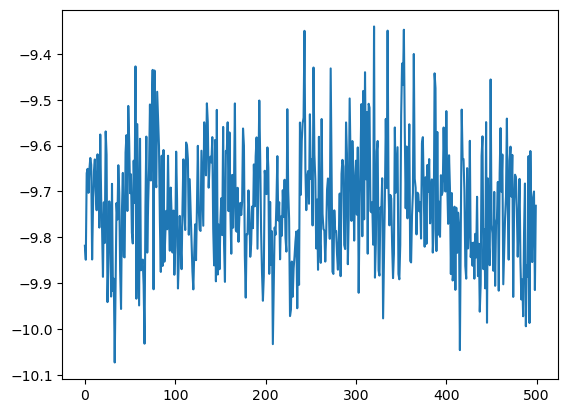

In [ ]:

plt.plot(dataset[:500])

In [ ]:
# def predict(model, dataset):
#   predictions, losses = [], []
#   # criterion = nn.L1Loss(reduction='sum').to(device)
#   with torch.no_grad():
#     model = model.eval()
#     for seq_true in dataset:
#       seq_true = seq_true.to(device)
#       # print('sequ true shape:', seq_true.shape)
#       _, seq_pred, _ = model(seq_true)

#       # loss = criterion(seq_pred, seq_true)
#       # print(seq_pred.shape)
#       predictions.append(seq_pred.cpu())
#       # losses.append(loss.item())
#   return predictions, losses


In [ ]:
predictions, losses = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2108\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


ValueError: too many values to unpack (expected 2)

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
#   criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      _, seq_pred, _ = model(seq_true)
      seq_pred = seq_pred[0, :]
    #   loss = criterion(seq_pred, seq_true)
      # print(seq_pred.shape)
      predictions.append(seq_pred.cpu().numpy().flatten())
    #   losses.append(loss.item())
  return predictions, losses

In [ ]:
predictions, losses = predict(model, test_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6056\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


252